In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [4]:
ns = 1000
c = 0.01
smin = 0.01
S = smin*(1+c)**np.arange(0,ns)

In [5]:
dn = 1
ln1pc = np.log(1+c)
deltfrac = 0.1
t_fact = 20
dt = deltfrac * 1/S[-1]
tmax = t_fact * 1/S[-1]
T = np.arange(0,tmax+dt,dt)

In [32]:
nPchecks = 21
Pchecktime = tmax*np.arange(0,nPchecks)/(nPchecks-1)

In [33]:
Pchecktime

array([0.        , 0.0048189 , 0.00963779, 0.01445669, 0.01927559,
       0.02409448, 0.02891338, 0.03373227, 0.03855117, 0.04337007,
       0.04818896, 0.05300786, 0.05782676, 0.06264565, 0.06746455,
       0.07228345, 0.07710234, 0.08192124, 0.08674014, 0.09155903,
       0.09637793])

In [89]:
def getnewFPDEn(OldF, dt, revtime, ns):
    #revtime = False -> F decay
    #revtime = True -> P growth
    if revtime:
        dt = -dt
    
    partial = np.zeros(ns)
    rhs = np.zeros(ns)
    
    partial[1:] = OldF[1:] - OldF[:-1]
    rhs[1:] = S[1:] * (OldF[1:]*ln1pc*dn + partial[1:])
    
    rhs = rhs*(-dt)
    newF = np.zeros(ns)
    newF[0] = 1
    for i in np.arange(1,ns):
        newF[i] = rhs[i] +  newF[i-1] +  (OldF[i] - OldF[i-1])
    return newF

In [113]:
def runevolve():
    F = np.full(ns, 1)
    P = np.exp(-tmax*S)
    OldF = F
    OldP = P
    chk_idx = 0
    
    Pcheck = []
    Fcheck = []
    for t in T:
        if (chk_idx<nPchecks) and (t >= Pchecktime[chk_idx]) :
            print(f"Saving P & F at time {t}")
            Pcheck.append(OldP) 
            Fcheck.append(OldF)
            chk_idx +=1
        F = getnewFPDEn(OldF, dt, revtime=False, ns=ns)
        P = getnewFPDEn(OldP, dt, revtime=True, ns=ns)
        OldF = F
        OldP = P
    return (F,P,Fcheck,Pcheck)

In [114]:
(F,P,Fcheck,Pcheck) = runevolve()

Saving P & F at time 0.0
Saving P & F at time 0.004818896416694335
Saving P & F at time 0.00963779283338867
Saving P & F at time 0.014456689250083003
Saving P & F at time 0.01927558566677734
Saving P & F at time 0.024094482083471674
Saving P & F at time 0.028913378500166006
Saving P & F at time 0.033732274916860344
Saving P & F at time 0.03855117133355468
Saving P & F at time 0.043370067750249014
Saving P & F at time 0.04818896416694335
Saving P & F at time 0.05300786058363768
Saving P & F at time 0.05782675700033201
Saving P & F at time 0.06264565341702635
Saving P & F at time 0.06746454983372069
Saving P & F at time 0.07228344625041502
Saving P & F at time 0.07710234266710936
Saving P & F at time 0.08192123908380369
Saving P & F at time 0.08674013550049803
Saving P & F at time 0.09155903191719236
Saving P & F at time 0.0963779283338867


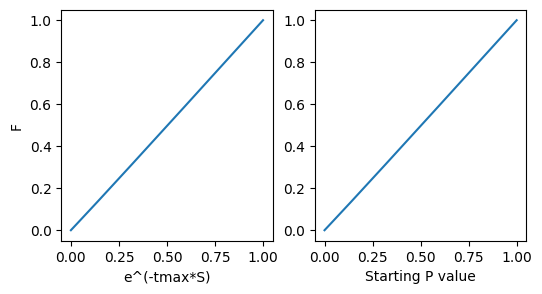

In [115]:
#Was F ok fig
fig,ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot(np.exp(-tmax*S),F)
ax[0].set_ylabel("F")
ax[0].set_xlabel("e^(-tmax*S)")
ax[1].plot(Pcheck[0],F)
ax[1].set_xlabel("Starting P value"); #which is also exp(-tmax*Svals)

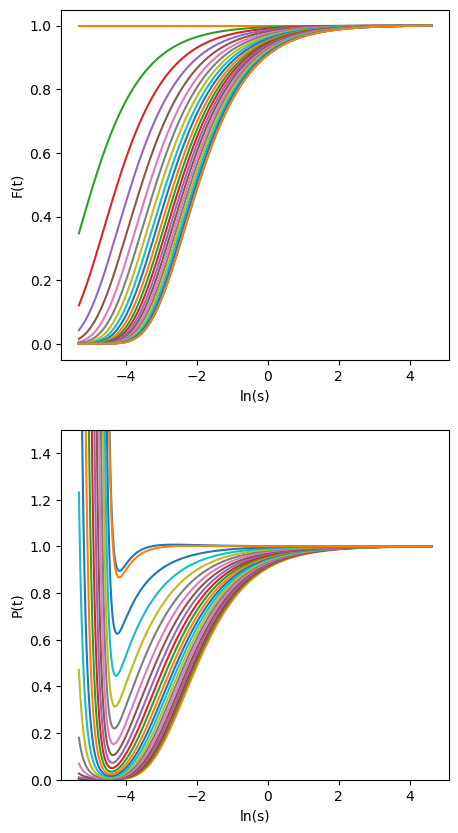

In [130]:
#evolve fig
fig,ax = plt.subplots(2,1, figsize = (5,10))
ax[0].plot(-np.log(S), F)
ax[0].set_ylabel("F(t)")
ax[0].set_xlabel("ln(s)")
for i in range(nPchecks):
    ax[0].plot(-np.log(S),Fcheck[i])
ax[1].plot(-np.log(S), P)
ax[1].set_ylabel("P(t)")
ax[1].set_xlabel("ln(s)")
ax[1].set_ylim(0,1.5)
for i in range(nPchecks):
    ax[1].plot(-np.log(S),Pcheck[i])

In [124]:
def stepbackandforth(t0=tmax, dt = dt,
               nsteps = 11, forward=True):
    startF = np.exp(-t0 * S)
    leaveF = np.zeros([nsteps,ns])
    retrnF = np.zeros([nsteps,ns])
    #start growth
    leaveF[0] = startF
    out = not forward
    for i in np.arange(1,nsteps):
        leaveF[i] = getnewFPDEn(leaveF[i-1], dt=dt, revtime=out, ns=ns)
    #start decay
    retrnF[0] = leaveF[-1]
    for i in np.arange(1,nsteps):
        retrnF[i] = getnewFPDEn(retrnF[i-1], dt=dt, revtime= not out, ns=ns)
    return (leaveF, retrnF)

Text(0.5, 1.0, 'PDE Growth')

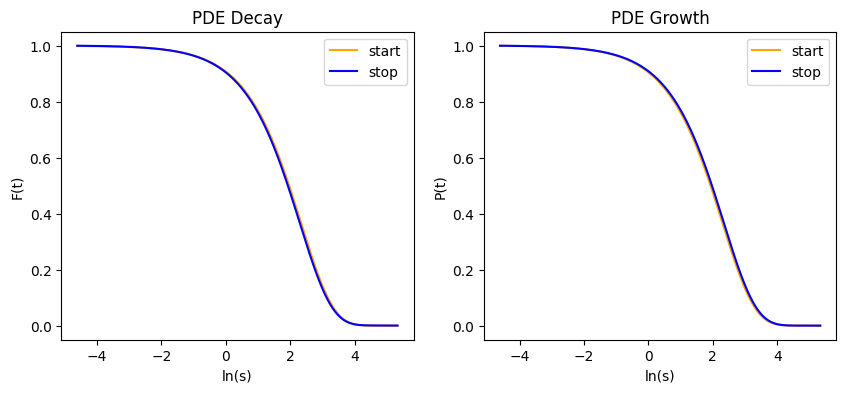

In [125]:
test = stepbackandforth(nsteps=10)
fig,ax = plt.subplots(1,2, figsize=(10,4))
nsteps = len(test[0][:,0])
ax[0].plot(np.log(S), test[0][0], color = 'orange', label='start')
ax[0].plot(np.log(S), test[0][-1], color = 'blue', label='stop')
ax[0].set_ylabel("F(t)")
ax[0].set_xlabel("ln(s)")
ax[0].set_title('PDE Decay')
ax[0].legend()
ax[1].plot(np.log(S), test[1][0], color = 'orange',label='start')
ax[1].plot(np.log(S), test[1][-1], color = 'blue',label='stop')
ax[1].legend()
ax[1].set_ylabel("P(t)")
ax[1].set_xlabel("ln(s)")
ax[1].set_title('PDE Growth')

In [119]:
#plt.plot(test[0][1],test[1][1])

In [120]:
os.getcwd()
PcheckR = pd.read_csv('newPDEdata.csv',index_col=0).to_numpy()

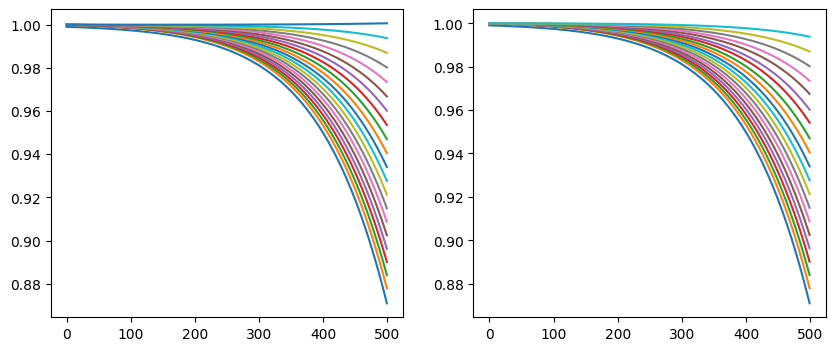

In [127]:
fig,ax = plt.subplots(1,2, figsize=(10,4))
for i in range(nPchecks):
    ax[0].plot(Pcheck[i][:500])
for i in range(20):
    ax[1].plot(PcheckR[i,:500])

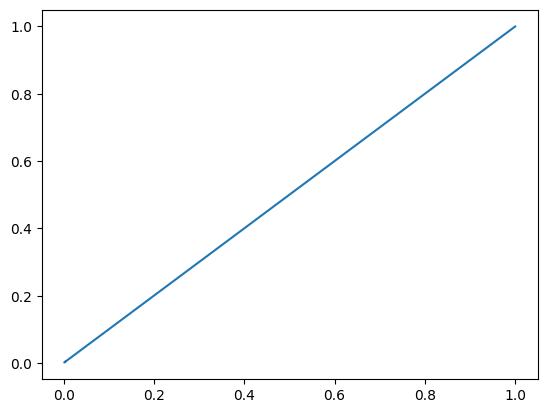

In [123]:
plt.plot(PcheckR[2],Pcheck[2]);